In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Descriptive Statistics

In [ ]:
metadata_df = pd.read_csv('download_data.csv')
df_list = [group.reset_index(drop=True) for _, group in metadata_df.groupby('repository')]

In [ ]:
n_releases = [len(df) for df in df_list]

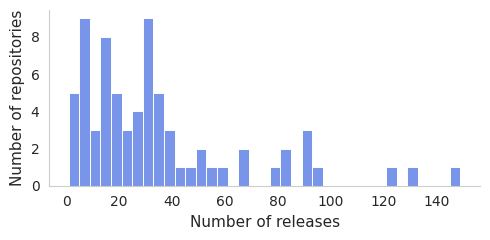

In [ ]:
sns.set_style("whitegrid", {"axes.grid": False, "ticks": False})

fig, ax = plt.subplots(figsize=(5, 2.5))
sns.histplot(n_releases,  color='royalblue', binwidth=4, alpha=.7)

plt.xlabel('Number of releases', fontsize=11)
plt.ylabel('Number of repositories', fontsize=11)

sns.despine(left=False, right=True, top=True, bottom=False)
ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig("dist_releases.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
file_counts = [int(l.strip()) for l in open('file_counts.txt').readlines()]

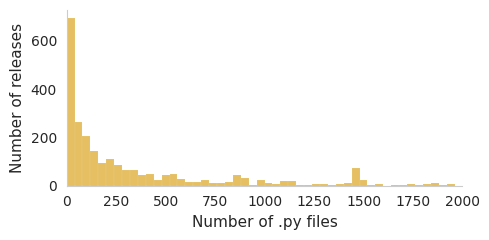

In [ ]:
sns.set_style("whitegrid", {"axes.grid": False, "ticks": False})

fig, ax = plt.subplots(figsize=(5, 2.5))
sns.histplot(file_counts,  color='goldenrod', binwidth=40, alpha=.7)

plt.xlabel('Number of .py files', fontsize=11)
plt.ylabel('Number of releases', fontsize=11)

sns.despine(left=False, right=True, top=True, bottom=False)
ax.tick_params(labelsize=10)
plt.xlim(0, 2000)

plt.tight_layout()
plt.savefig("dist_files.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Lifelong Code Change Analysis

In [ ]:
df = pd.read_json('gensim.jsonl', lines=True)
grouped_df = df.groupby('branch')

In [ ]:
branch_statistics = []
for i, (branch, branch_df) in enumerate(grouped_df):
  if i == 0:
    continue

  files_mapped = branch_df.loc[branch_df['mapping'].apply(lambda x: x not in ['added', 'removed'])]

  added_count = branch_df.loc[branch_df['mapping'].apply(lambda x: x == 'added')].shape[0]
  removed_count = branch_df.loc[branch_df['mapping'].apply(lambda x: x == 'removed')].shape[0]
  mapped_count = files_mapped.shape[0]

  statistics = {
    'n_files_changed': 0,
    'n_files_unchanged': 0,
    'methods_ratio': [],
    'methods_dist': [],
    'n_methods_changed': 0,
    'n_methods_unchanged': 0
  }

  for index, row in files_mapped.iterrows():
        methods = row['methods']
        methods = [m for m in methods if m['mapping'] not in ['added', 'removed']]

        if len(methods) == 0:
            statistics['n_files_unchanged'] += 1
            continue

        methods_ratios = [m['statistics'] for m in methods]
        methods_changed = [m for m in methods_ratios if m['ratio'] < 1]
        methods_unchanged = [m for m in methods_ratios if m['ratio'] == 1]

        statistics['n_methods_changed'] += len(methods_changed)
        statistics['n_methods_unchanged'] += len(methods_unchanged)

        if len(methods_changed) > 0:
          statistics['n_files_changed'] += 1
        else:
          statistics['n_files_unchanged'] += 1

        statistics['methods_ratio'].extend([m['ratio'] for m in methods_changed])
        statistics['methods_dist'].extend([m['dist'] for m in methods_changed])

  avg_ratio, avg_dist = 1, 0
  if statistics['methods_ratio'] != []:
    avg_ratio = sum(statistics['methods_ratio']) / len(statistics['methods_ratio'])
  if statistics['methods_dist'] != []:
    avg_dist = sum(statistics['methods_dist']) / len(statistics['methods_dist'])

  branch_statistics.append({
    'branch': branch,
    'files_added': added_count,
    'files_removed': removed_count,
    'files_mapped': mapped_count,
    'n_files_changed': statistics['n_files_changed'],
    'n_files_unchanged': statistics['n_files_unchanged'],
    'n_methods_changed': statistics['n_methods_changed'],
    'n_methods_unchanged': statistics['n_methods_unchanged'],
    'methods_avg_ratio': avg_ratio,
    'methods_avg_dist': avg_dist
  })

df = pd.DataFrame(branch_statistics)

In [ ]:
df['branch'] = list(range(1, len(df) + 1))
df

,branch,files_added,files_removed,files_mapped,n_files_changed,n_files_unchanged,n_methods_changed,n_methods_unchanged,methods_avg_ratio,methods_avg_dist
0,1,6,10,54,14,40,33,369,0.930622,76.696970
1,2,13,7,53,5,48,12,375,0.955916,102.666667
2,3,9,5,61,13,48,41,405,0.902495,119.658537
3,4,11,11,59,13,46,29,410,0.930807,197.344828
4,5,19,8,62,16,46,55,459,0.931070,154.745455
...,...,...,...,...,...,...,...,...,...,...
72,73,12,12,115,0,115,0,1696,1.000000,0.000000
73,74,12,12,115,22,93,57,1637,0.936460,120.929825
74,75,15,13,114,11,103,27,1650,0.974678,34.148148
75,76,14,14,115,4,111,5,1751,0.944561,164.800000


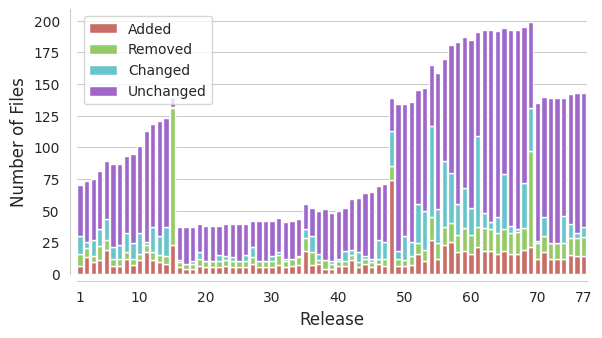

In [ ]:
plt.figure(figsize=(6, 3.5))

custom_palette = sns.color_palette("hls", n_colors=4)

ax = sns.barplot(x='branch', y='files_added', data=df, label='Added', color=custom_palette[0])
sns.barplot(x='branch', y='files_removed', data=df, label='Removed', color=custom_palette[1], bottom=df['files_added'])
sns.barplot(x='branch', y='n_files_changed', data=df, label='Changed', color=custom_palette[2], bottom=df['files_added']+df['files_removed'])
sns.barplot(x='branch', y='n_files_unchanged', data=df, label='Unchanged', color=custom_palette[3],  bottom=df['files_added']+df['files_removed']+df['n_files_changed'])

plt.xlabel('Release', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.legend()

xticks_positions = [0, 9, 19, 29, 39, 49, 59, 69, 76]
xticks_labels = df['branch'].iloc[xticks_positions]

ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=45, ha='right')

plt.tight_layout()
sns.despine(left=False, right=True, top=True, bottom=False, offset=5)
plt.savefig('gensim_files_changes.pdf', bbox_inches='tight')

plt.show()

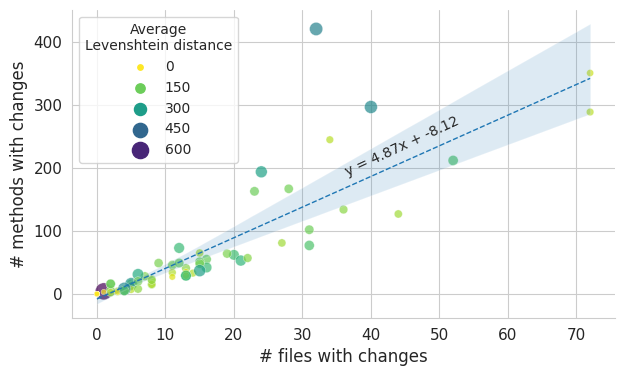

In [ ]:
sns.set_style("whitegrid", {"axes.grid": True, "ticks": True})

plt.figure(figsize=(7, 4))

scatter_plot = sns.scatterplot(x='n_files_changed', y='n_methods_changed', hue='methods_avg_dist', palette='viridis_r', data=df, size='methods_avg_dist', sizes=(15, 150), alpha=0.7)
sns.regplot(x='n_files_changed', y='n_methods_changed', data=df, scatter=False, ax=scatter_plot, line_kws={'linestyle': '--', 'linewidth': 1})

slope, intercept = np.polyfit(df['n_files_changed'], df['n_methods_changed'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
plt.annotate(equation, xy=(0.5, 0.46), xycoords='axes fraction', rotation=25, fontsize=10)

plt.xlabel('# files with changes', fontsize=12)
plt.ylabel('# methods with changes', fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

legend = scatter_plot.legend(title='Average\nLevenshtein distance', fontsize=10)
legend.get_title().set_multialignment('center')

sns.despine(left=False, right=True, top=True, bottom=False)
ax.tick_params(left=True, bottom=True)

plt.savefig('levenshtein.pdf', bbox_inches='tight')

plt.show()